# Lab - Disease prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
import warnings
import joblib

I det här momentet kommer vi jobba med ett dataset med data för hjärt-kärlsjukdom. Börja med att ladda
ned datasetet från Kaggle och läs på vad de olika features betyder. Notera att detta dataset innehåller
många felaktigheter, exempelvis finns negativa blodtryck och blodtryck som är omöjligt höga.

### Data description

There are 3 types of input features:

Objective: factual information;  <br>
Examination: results of medical examination;  <br>
Subjective: information given by the patient.  <br>
<br>
Features: 

Age | Objective Feature | age | int (days)  <br>
Height | Objective Feature | height | int (cm) |  <br>
Weight | Objective Feature | weight | float (kg) |  <br>
Gender | Objective Feature | gender | categorical code | 1: women, 2: men  <br>
Systolic blood pressure | Examination Feature | ap_hi | int |  <br>
Diastolic blood pressure | Examination Feature | ap_lo | int |  <br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |  <br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |  <br>
Smoking | Subjective Feature | smoke | binary |  <br>
Alcohol intake | Subjective Feature | alco | binary |  <br>
Physical activity | Subjective Feature | active | binary |  <br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |  <br>
All of the dataset values were collected at the moment of medical examination. 

However, there is no information about what the values of the binary variables represent. I will assume that 0 means not present/no and 1 means present/yes.

In [2]:
df_cardio = pd.read_csv("Data/cardio_train.csv", sep=";")
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [3]:
df_cardio.describe() #There seems to be some strange values (for example 16020 for ap_hi)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_cardio.info() # No missig values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


## 2.0 - EDA uppvärmning

Använd pandas, matplotlib och seaborn för att besvara på följande frågor för datasetet:

a) Hur många är positiva för hjärt-kärlsjukdom och hur många är negativa?

In [5]:
cardio_count = df_cardio["cardio"].value_counts().to_frame()

print(f"Number of positive cases for cardiovascular disease: {cardio_count['cardio'].iloc[1]}")
print(f"Number of negative cases for cardiovascular disease: {cardio_count['cardio'].iloc[0]}")

Number of positive cases for cardiovascular disease: 34979
Number of negative cases for cardiovascular disease: 35021


Our data is balanced.

b) Hur stor andel har normala, över normala och långt över normala kolesterolvärden? Rita ett tårtdiagram.

In [7]:
cholesterol_count = df_cardio["cholesterol"].value_counts().to_frame()
cholesterol_count

,cholesterol
1,52385
2,9549
3,8066


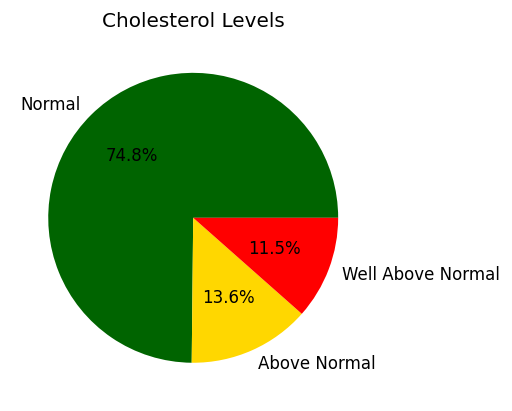

In [8]:
fig, ax = plt.subplots(dpi=120, facecolor="white")
plt.pie(cholesterol_count["cholesterol"], 
            labels=["Normal", "Above Normal", "Well Above Normal"], 
            colors=["darkgreen", "gold", "red"],
            autopct="%1.1f%%")
ax.set_title("Cholesterol Levels");

c) Hur ser åldersfördelningen ut? Rita ett histogram.

In [3]:
ages = pd.DataFrame({"Age": df_cardio["age"]/365})
print(f"Youngest person is {ages.min()[0]:.1f} years old. Oldest person is {ages.max()[0]:.1f} years old.")

Youngest person is 29.6 years old. Oldest person is 65.0 years old.


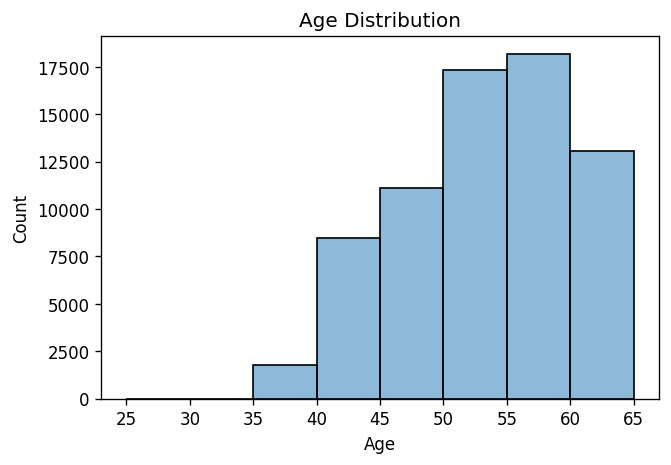

In [5]:
fig = plt.figure(dpi=120)
ax = sns.histplot(ages, bins=range(25, 70, 5), legend=False)
ax.set(title="Age Distribution", xlabel="Age");

d) Hur stor andel röker?

In [9]:
print(f"{df_cardio['smoke'].sum()/len(df_cardio['smoke'])*100:.1f}% of the participants smoke.")

8.8% of the participants smoke.


e) Hur ser viktfördelningen ut? Rita lämpligt diagram.

In [11]:
print(f"Lightest person weighs {df_cardio['weight'].min()} kg. Heaviest person weighs {df_cardio['weight'].max()} kg.")

Lightest person weighs 10.0 kg. Heaviest person weighs 200.0 kg.


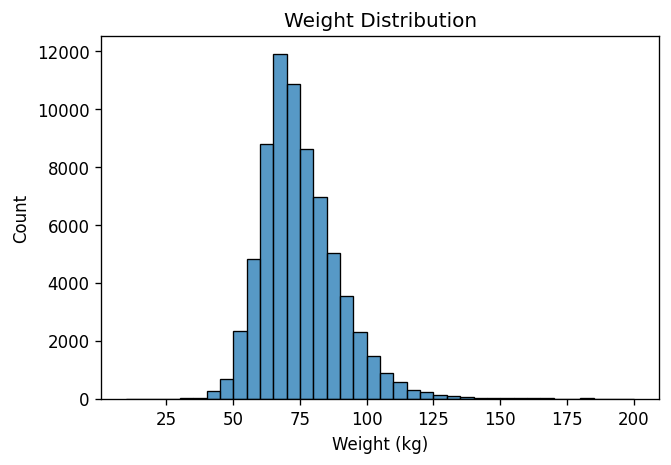

In [17]:
fig = plt.figure(dpi=120)
ax = sns.histplot(df_cardio["weight"], bins=range(10, 205, 5))
ax.set(title="Weight Distribution", xlabel="Weight (kg)");

f) Hur ser längdfördelningen ut? Rita lämpligt diagram.

In [13]:
print(f"Shortest person is {df_cardio['height'].min()} cm. Tallest person is {df_cardio['height'].max()} cm.")

Shortest person is 55 cm. Tallest person is 250 cm.


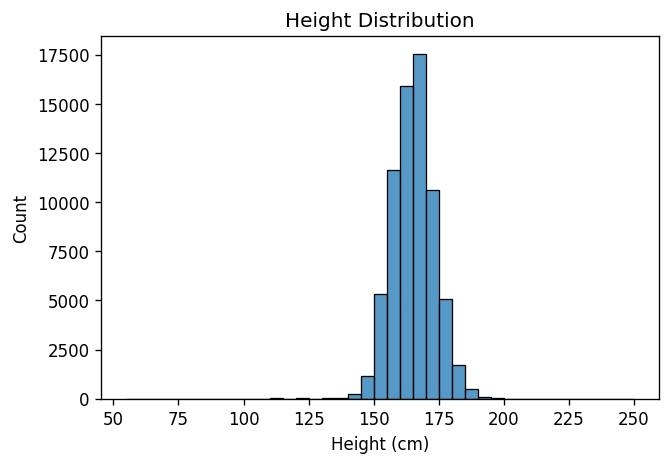

In [13]:
fig = plt.figure(dpi=120)
ax = sns.histplot(df_cardio["height"], bins=range(55, 255, 5))
ax.set(title="Height Distribution", xlabel="Height (cm)");

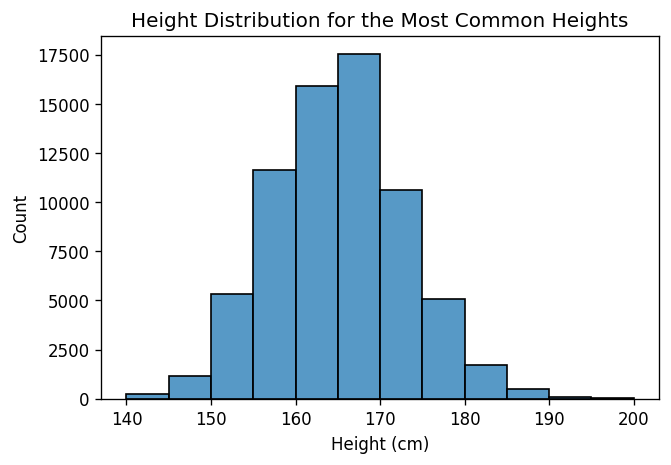

In [14]:
fig = plt.figure(dpi=120)
ax = sns.histplot(df_cardio["height"], bins=range(140, 205, 5))
_ = ax.set(title="Height Distribution for the Most Common Heights", xlabel="Height (cm)")

g) Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom? Rita lämpligt diagram

In [18]:
cardio_gender = pd.DataFrame({"cardio":df_cardio["cardio"].groupby(df_cardio["gender"]).sum(), 
                            "gender":df_cardio["gender"].value_counts()})
cardio_gender["%"] = (cardio_gender["cardio"] / cardio_gender["gender"] * 100).round(2)
cardio_gender

,cardio,gender,%
1,22616,45530,49.67
2,12363,24470,50.52


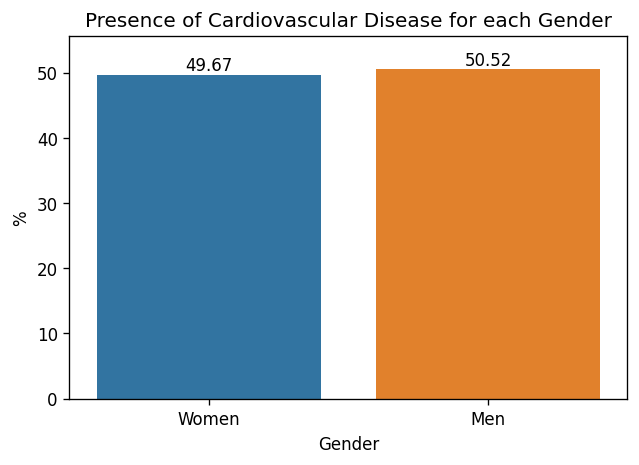

In [19]:
fig = plt.figure(dpi=120)
ax = sns.barplot(data=cardio_gender, x=["Women", "Men"], y="%")
ax.set(xlabel="Gender", title="Presence of Cardiovascular Disease for each Gender")
ax.bar_label(ax.containers[0])
ax.margins(y=0.1)

## 2.1.0 - Feature engineering BMI
Skapa en feature för BMI (Body Mass Index), läs på om formeln på wikipedia.

a) Släng de samples med orimliga BMIer och outliers. Notera att detta kan vara svårt att avgöra i vilket
range av BMIer som vi ska spara. Beskriv hur du gör avvägningen.

In [20]:
df_cardio["BMI"] = df_cardio["weight"] / ((df_cardio["height"]/100)**2)
df_cardio["BMI"]

0        21.967120
1        34.927679
2        23.507805
3        28.710479
4        23.011177
           ...    
69995    26.927438
69996    50.472681
69997    31.353579
69998    27.099251
69999    24.913495
Name: BMI, Length: 70000, dtype: float64

In [19]:
print(f"The lowest BMI is {df_cardio['BMI'].min():.2f} and the highest is {df_cardio['BMI'].max():.2f}.")
print("These values are not realistic.")

The lowest BMI is 3.47 and the highest is 298.67.
These values are not realistic.


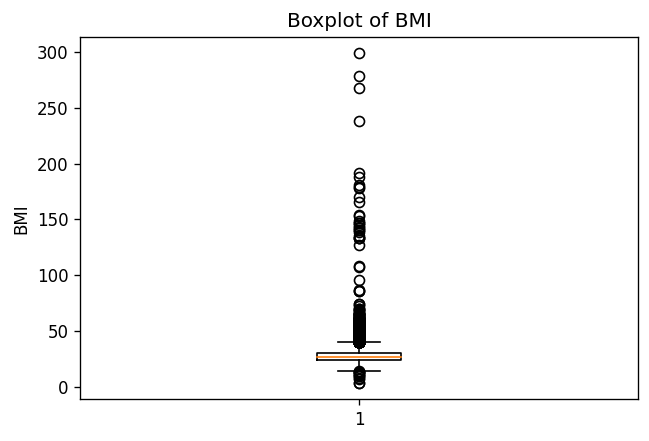

In [20]:
fig, ax = plt.subplots(dpi=120)
ax.boxplot(df_cardio["BMI"]);
ax.set_title("Boxplot of BMI")
ax.set_ylabel("BMI");

As can be seen above, the BMI data is extremely skewed. We have some values very close to 0 and some very high values. Some of these values are impossible. Since the data is skewed, we should not use z-values for outlier detection. Instead we can use the interquartile range rule to detect outliers. 

In [23]:
def outlier_cut_off(data:pd.Series) -> tuple[float]:
    """
    Identifies outliers according to the interquartile range (IQR) rule.
    
    Parameters
    ----------
    data : pd.Series
        The variable to calculate outliers for.
    
    Returns
    -------
    outlier_low : float
        Observations smaller than this value should be considered outliers.
    outlier_high : float
        Observations larger than this value should be considered outliers.
    """

    quant25 = np.percentile(data, q=25)
    quant75 = np.percentile(data, q=75)
    iqr = quant75 - quant25

    outlier_low = quant25 - 1.5 * iqr
    outlier_high = quant75 + 1.5 * iqr

    return outlier_low, outlier_high

In [24]:
outlier_low_bmi, outlier_high_bmi = outlier_cut_off(df_cardio["BMI"])
print(f"According to the IQR-rule, values below {outlier_low_bmi:.2f} are outliers.")
print(f"According to the IQR-rule, values above {outlier_high_bmi:.2f} are outliers.")

According to the IQR-rule, values below 14.35 are outliers.
According to the IQR-rule, values above 39.74 are outliers.


Somewhat interesting is that there are more observations exactly equal to the first quartile than the third quartile, as can be seen below. This leads to that the quartiles do not have the same size. 

In [25]:
bmi_quant25 = np.percentile(df_cardio["BMI"], q=25)
bmi_quant75 = np.percentile(df_cardio["BMI"], q=75)

print(f"Observations in first quartile: {len(df_cardio[df_cardio['BMI'] < bmi_quant25])}")
print(f"Observations in forth quartile: {len(df_cardio[df_cardio['BMI'] > bmi_quant75])}")

print(f"Number of observations exactly equal to the first quantile value: {len(df_cardio[df_cardio['BMI'] == bmi_quant25])}")
print(f"Number of observations exactly equal to the third quantile value: {len(df_cardio[df_cardio['BMI'] == bmi_quant75])}")

values_first_quantile = df_cardio[df_cardio["BMI"] == bmi_quant25]
print(f"There are {len(df_cardio[df_cardio['BMI'] == bmi_quant25])} people with a height of {values_first_quantile['height'].iloc[0]} and a weight of {values_first_quantile['weight'].iloc[0]}.")

Observations in first quartile: 17194
Observations in forth quartile: 17483
Number of observations exactly equal to the first quantile value: 943
Number of observations exactly equal to the third quantile value: 29
There are 943 people with a height of 165 and a weight of 65.0.


If we were to classify an outlier as being a person with a BMI above 39.7 (as calculated by the IQR rule), we would not be able to classify any observations to obesity class 3 (BMI above 40). Some studies have used an even higher obesity category, that is obesity class 4, which is defined as having a BMI above 50.<a href="#Mulder(2016)" id="note1ref"><sup>1</sup></a> Based on this, I therefore decide to omit observations with a BMI above 50. The lower value for outliers, 14.4, seems reasonable, since the cutoff for underweight is at 18.5.

In [24]:
print(f"There are {len(df_cardio[(df_cardio['BMI'] > 40) & (df_cardio['BMI'] < 50)])} observations with a BMI between 40 and 50.")
print(f"There are {len(df_cardio[df_cardio['BMI'] < outlier_low_bmi])} observations with a BMI below {outlier_low_bmi:.1f}.")
print(f"There are {len(df_cardio[df_cardio['BMI'] >= 50])} observations with a BMI of 50 or above.")

There are 1628 observations with a BMI between 40 and 50.
There are 13 observations with a BMI below 14.4.
There are 244 observations with a BMI of 50 or above.


I continue with removing all observations with a BMI below 14.4 (*n* = 13) or above/equal to 50 (*n* = 244). 

In [26]:
df_cardio = df_cardio[(df_cardio["BMI"] >= outlier_low_bmi ) & (df_cardio["BMI"] < 50)] 
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


In [26]:
print(f"Minimum BMI: {df_cardio['BMI'].min():.1f}, Maximum BMI: {df_cardio['BMI'].max():.1f} (rounded).")
print(f"Minimum height: {df_cardio['height'].min()} cm, Maximum height: {df_cardio['height'].max():.0f} cm")
print(f"Minimum weight: {df_cardio['weight'].min():.0f} kg, Maximum weight: {df_cardio['weight'].max():.0f} kg")

Minimum BMI: 14.5, Maximum BMI: 50.0 (rounded).
Minimum height: 98 cm, Maximum height: 207 cm
Minimum weight: 28 kg, Maximum weight: 180 kg


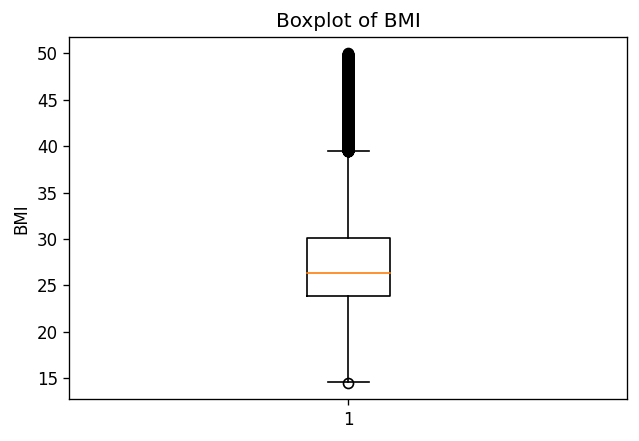

In [27]:
fig, ax = plt.subplots(dpi=120)
ax.boxplot(df_cardio["BMI"]);
ax.set_title("Boxplot of BMI")
ax.set_ylabel("BMI");

The shortest person is 98 cm. However, since dwarfism is a risk factor for cardiovascular disease<a href="#Wynn(2007)" id="note2ref"><sup>2</sup></a>, I choose to keep values as small as this. If we were to remove them, it is possible that we would not get good predictions for cardiovascular disease for similar heights.

b) Skapa en kategorisk BMI-feature med kategorierna: normal range, overweight, obese (class I), obese
(class II), obese (class III).

Since a low BMI is also a risk factor for cardiovascular disease<a href="#Park(2017)" id="note3ref"><sup>3</sup></a>, I also choose to create a category for underweight. 

In [28]:
# Create categories. Reference: https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable
df_cardio=df_cardio.assign(BMI_category=np.nan)
df_cardio.loc[(df_cardio["BMI"] < 18.5), "BMI_category"] = "Underweight"
df_cardio.loc[(df_cardio["BMI"] >= 18.5) & (df_cardio["BMI"] <= 25), "BMI_category"] = "Normal Weight"
df_cardio.loc[(df_cardio["BMI"] > 25) & (df_cardio["BMI"] <= 30), "BMI_category"] = "Overweight"
df_cardio.loc[(df_cardio["BMI"] > 30) & (df_cardio["BMI"] <= 35), "BMI_category"] = "Obesity Class 1"
df_cardio.loc[(df_cardio["BMI"] > 35) & (df_cardio["BMI"] <= 40), "BMI_category"] = "Obesity Class 2"
df_cardio.loc[(df_cardio["BMI"] > 40), "BMI_category"] = "Obesity Class 3"
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,Normal Weight
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Obesity Class 1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Normal Weight
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Overweight
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,Normal Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,Overweight
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,Overweight
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,Obesity Class 1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,Overweight


In [29]:
print(f"Missing values: {df_cardio['BMI_category'].isna().sum()}")
df_cardio["BMI_category"].value_counts()

Missing values: 0


Normal Weight      25804
Overweight         25073
Obesity Class 1    12211
Obesity Class 2     4390
Obesity Class 3     1628
Underweight          637
Name: BMI_category, dtype: int64

## 2.1.1 - Feature engineering blodtryck
Släng bort samples med orimliga blodtryck och outliers. Likt uppgift 2.1.0 är det inte trivialt att sätta
gränserna. Skapa en feature för blodtryckskategorier enligt tabellen i denna artikel.<a href="#Holland(2021)" id="note4ref"><sup>4</sup></a>

As can be seen on the boxplots below we have some extremely high and unrealistic blood pressures, which we need to remove. 

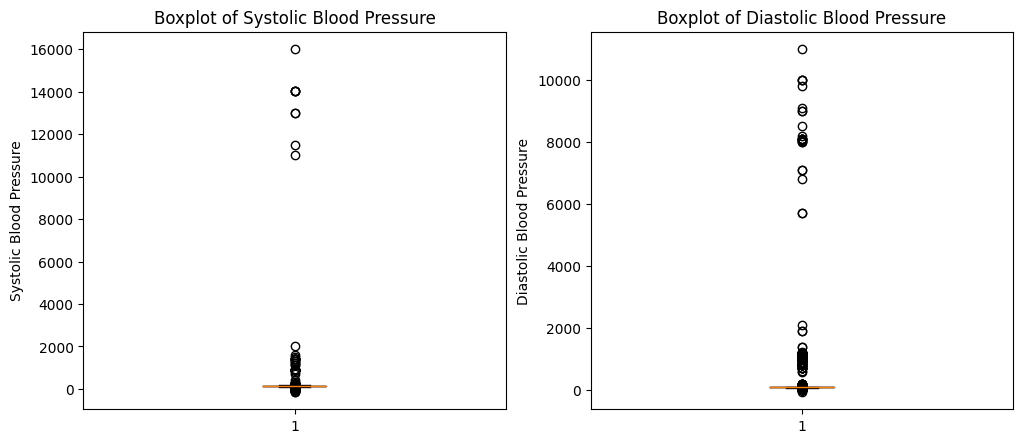

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

for ax, feature, name in zip(axes, ["ap_hi", "ap_lo"], ["Systolic", "Diastolic"]):
    ax.boxplot(df_cardio[feature]);
    ax.set_title(f"Boxplot of {name} Blood Pressure")
    ax.set_ylabel(f"{name} Blood Pressure");

We also have negative values. 

In [31]:
print(f"Minimum Systolic Blood Pressure: {df_cardio['ap_hi'].min()}, Maximum Systolic Blood Pressure: {df_cardio['ap_hi'].max()}")
print(f"Minimum Diastolic Blood Pressure: {df_cardio['ap_lo'].min()}, Maximum Diastolic Blood Pressure: {df_cardio['ap_hi'].max()}") 

Minimum Systolic Blood Pressure: -150, Maximum Systolic Blood Pressure: 16020
Minimum Diastolic Blood Pressure: -70, Maximum Diastolic Blood Pressure: 16020


### Systolic Blood Pressure - Data Cleaning

I start with detecting outliers based on the IQR rule (since the data is skewed), and continue exploring the data.

In [29]:
outlier_low_ap_hi, outlier_high_ap_hi = outlier_cut_off(df_cardio["ap_hi"])
print(f"According to the IQR-rule, values below {outlier_low_ap_hi:.0f} are outliers for the systolic blood pressure.")
print(f"According to the IQR-rule, values above {outlier_high_ap_hi:.0f} are outliers for the systolic blood pressure.")

According to the IQR-rule, values below 90 are outliers for the systolic blood pressure.
According to the IQR-rule, values above 170 are outliers for the systolic blood pressure.


There are more people who have values that are exactly equal to the first quantile than the third quantile. 

In [30]:
ap_hi_quant25= np.percentile(df_cardio["ap_hi"], q=25)
ap_hi_quant75= np.percentile(df_cardio["ap_hi"], q=75)

print(f"Number of observations exactly equal to the first quantile value: {len(df_cardio[df_cardio['ap_hi'] == ap_hi_quant25])}")
print(f"Number of observations exactly equal to the third quantile value: {len(df_cardio[df_cardio['ap_hi'] == ap_hi_quant75])}")

Number of observations exactly equal to the first quantile value: 27621
Number of observations exactly equal to the third quantile value: 9460


In [34]:
for blood_pressure in range(100, 0, -10):
    print(f"There are {len(df_cardio[df_cardio['ap_hi'] < blood_pressure])} people with a systolic blood pressure below {blood_pressure}.")

There are 1347 people with a systolic blood pressure below 100.
There are 320 people with a systolic blood pressure below 90.
There are 206 people with a systolic blood pressure below 80.
There are 188 people with a systolic blood pressure below 70.
There are 187 people with a systolic blood pressure below 60.
There are 187 people with a systolic blood pressure below 50.
There are 187 people with a systolic blood pressure below 40.
There are 187 people with a systolic blood pressure below 30.
There are 182 people with a systolic blood pressure below 20.
There are 10 people with a systolic blood pressure below 10.


In [35]:
for blood_pressure in range(170, 260, 10):
    print(f"There are {len(df_cardio[df_cardio['ap_hi'] > blood_pressure])} people with a systolic blood pressure above {blood_pressure}.")

print(f"\nThere are {len(df_cardio[df_cardio['ap_hi'] > 700])} people with a systolic blood pressure above 700")

There are 1097 people with a systolic blood pressure above 170.
There are 362 people with a systolic blood pressure above 180.
There are 214 people with a systolic blood pressure above 190.
There are 99 people with a systolic blood pressure above 200.
There are 73 people with a systolic blood pressure above 210.
There are 48 people with a systolic blood pressure above 220.
There are 47 people with a systolic blood pressure above 230.
There are 40 people with a systolic blood pressure above 240.
There are 40 people with a systolic blood pressure above 250.

There are 38 people with a systolic blood pressure above 700


##### Outliers

For systolic blood pressure, we have many extreme and unrealistic values (e.g. 38 observations with values above 700, see above). According to the results above for outlier detection, we should not include systolic blood pressures below 90 or above 170. 

##### Lower Limit

Low blood pressure is sometimes defined as values below 90/60 (systolic/diastolic).<a href="#MayoClinicStaff(2020)" id="note5ref"><sup>5</sup></a> The IQR rule defines outliers for systolic blood pressure as values below 90. From the print above we can see that there are only 320 observations below 90 (and 1374 observations below 100). Some of the models I will use (for example Support Vector Classifier) are sensitive to outliers, and I therefore choose a cutoff of 90 (including).

##### Upper Limit

A hypertensive crisis is classified as having a systolic blood pressure of above 180 (and/or a diastolic blood pressure above 120).<a href="#Holland(2021)" id="note4ref"><sup>4</sup></a> Since my goal is to identify cardiovascular disease, I also want to include people in the hypertensive group. I therefore want to choose a somewhat higher cutoff. Based on the results above, it seems reasonable to construct a group for people with systolic blood pressures between 180 and 220. According to a previous study, it is even common for patients with an underlying hypertensive disease to have systolic blood pressures larger than 220 mmHg.<a href="#Gegenhuber(2003)" id="note6ref"><sup>6</sup></a> Setting a cutoff of 220, would give the hypertensive group the range 180-220. We can also see from the print above that this cutoff lets us keep a lot of the data (there are only 10 people in the group 220-700).

### Diastolic Blood Pressure - Data Cleaning

I start with detecting outliers for the diastolic blood pressure based on the IQR rule (since the data is skewed) and continue with some other explorations. 

In [31]:
outlier_low_ap_lo, outlier_high_ap_lo = outlier_cut_off(df_cardio["ap_lo"])
print(f"According to the IQR-rule, values below {outlier_low_ap_lo:.0f} are outliers for the diastolic blood pressure.")
print(f"According to the IQR-rule, values above {outlier_high_ap_lo:.0f} are outliers for the diastolic blood pressure.")

According to the IQR-rule, values below 65 are outliers for the diastolic blood pressure.
According to the IQR-rule, values above 105 are outliers for the diastolic blood pressure.


There are more people who have values that are exactly equal to the first quantile than the third quantile. 

In [37]:
ap_lo_quant25= np.percentile(df_cardio["ap_lo"], q=25)
ap_lo_quant75= np.percentile(df_cardio["ap_lo"], q=75)

print(f"Number of observations exactly equal to the first quantile value: {len(df_cardio[df_cardio['ap_lo'] == ap_lo_quant25])}")
print(f"Number of observations exactly equal to the third quantile value: {len(df_cardio[df_cardio['ap_lo'] == ap_lo_quant75])}")
print(f"There are {len(df_cardio[df_cardio['ap_lo'] < 65])} people with a diastolic blood pressure below 65.")
print(f"There are {len(df_cardio[df_cardio['ap_lo'] > 105])} people with a diastolic blood pressure above 105.")

Number of observations exactly equal to the first quantile value: 34744
Number of observations exactly equal to the third quantile value: 14243
There are 2925 people with a diastolic blood pressure below 65.
There are 1681 people with a diastolic blood pressure above 105.


In [38]:
for i in range(70, 0, -10):
    print(f"There are {len(df_cardio[df_cardio['ap_lo'] < i])} people with a diastolic blood pressure below {i}.")

There are 3146 people with a diastolic blood pressure below 70.
There are 174 people with a diastolic blood pressure below 60.
There are 79 people with a diastolic blood pressure below 50.
There are 58 people with a diastolic blood pressure below 40.
There are 52 people with a diastolic blood pressure below 30.
There are 37 people with a diastolic blood pressure below 20.
There are 29 people with a diastolic blood pressure below 10.


In [39]:
for i in range(105, 165, 5):
    print(f"There are {len(df_cardio[df_cardio['ap_lo'] > i])} people with a diastolic blood pressure above {i}.")
print(f"\nThere are {len(df_cardio[df_cardio['ap_lo'] > 900])} people with a diastolic blood pressure above 900.")

There are 1681 people with a diastolic blood pressure above 105.
There are 1267 people with a diastolic blood pressure above 110.
There are 1251 people with a diastolic blood pressure above 115.
There are 1046 people with a diastolic blood pressure above 120.
There are 1042 people with a diastolic blood pressure above 125.
There are 1006 people with a diastolic blood pressure above 130.
There are 1005 people with a diastolic blood pressure above 135.
There are 975 people with a diastolic blood pressure above 140.
There are 975 people with a diastolic blood pressure above 145.
There are 967 people with a diastolic blood pressure above 150.
There are 967 people with a diastolic blood pressure above 155.
There are 958 people with a diastolic blood pressure above 160.

There are 917 people with a diastolic blood pressure above 900.


##### Outliers

According to the IQR (see above), values below 65 and above 105 should be considered outliers. Again, since I would like to be able to classify people to the hypertensive group, I would like to have a higher cutoff (and possibly also a lower one).

##### Lower Limit

There are quite a lot of observations with values below 65 for the diastolic blood pressure (*n* = 2925). Low blood pressure is sometimes defined as a blood pressure below 90/60 (systolic/diastolic).<a href="#MayoClinicStaff(2020)" id="note5ref"><sup>5</sup></a> The IQR rule defines outliers for diastolic blood pressure as values below 65. However, this would lead to removing 2925 observations. Setting a cutoff of 60, in accordance with the definition for low blood pressure, would lead to only removing 174 observations. I therefore choose a cutoff of 60 for the diastolic blood pressure. 

##### Upper Limit

Again, we would like to be able to create a hypertensive group from our data. From the print above it seems reasonable to choose a cutoff of 140, since the number of observations after that drops very slowly (see above). This also makes it possible to create a hypertensive group, defined as having a diastolic blood pressure above 120 (or a systolic blood pressure above 180)<a href="#Holland(2021)" id="note4ref"><sup>4</sup></a>.

##### Chosen Cut-Offs

I have thus chosen the following range of values: 

Systolic: 90-220 (both values included)  <br>
Diastolic: 60-140 (both values included)

In [32]:
df_cardio = df_cardio[(df_cardio["ap_hi"] >= outlier_low_ap_hi ) & (df_cardio["ap_hi"] <= 220) 
                    & (df_cardio["ap_lo"] >= 60 ) & (df_cardio["ap_lo"] <= 140)]
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,Normal Weight
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Obesity Class 1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Normal Weight
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Overweight
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,Normal Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,Overweight
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,Overweight
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,Obesity Class 1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,Overweight


It is not possible for the diastolic blood pressure to be higher or equal to the systolic blood pressure, and I therefore remove these cases. 

In [41]:
print(f"In {len(df_cardio[df_cardio['ap_lo'] >= df_cardio['ap_hi']])} cases the diastolic blood pressure is equal to or higher than the systolic blood pressure.")

In 26 cases the diastolic blood pressure is equal to or higher than the systolic blood pressure.


In [33]:
df_cardio[df_cardio['ap_lo'] >= df_cardio['ap_hi']].head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category
4825,6836,19618,2,164,89.0,90,140,2,2,0,0,1,1,33.090422,Obesity Class 1
5121,7277,17600,2,173,78.0,90,140,1,1,0,1,1,1,26.061679,Overweight
5446,7737,18968,1,165,110.0,95,130,1,1,0,1,1,1,40.404040,Obesity Class 3
9010,12847,20400,2,176,82.0,90,130,3,3,0,0,1,1,26.472107,Overweight
10748,15369,20743,2,170,77.0,90,130,1,1,0,0,0,0,26.643599,Overweight


In [34]:
# Removing the cases
df_cardio = df_cardio[df_cardio['ap_lo'] < df_cardio['ap_hi']]
df_cardio

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI,BMI_category
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,Normal Weight
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,Obesity Class 1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,Normal Weight
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,Overweight
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,Normal Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,Overweight
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,Overweight
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,Obesity Class 1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,Overweight


In [44]:
print(f"Minimum Systolic Blood Pressure: {df_cardio['ap_hi'].min()}, Maximum Systolic Blood Pressure: {df_cardio['ap_hi'].max()}")
print(f"Minimum Diastolic Blood Pressure: {df_cardio['ap_lo'].min()}, Maximum Diastolic Blood Pressure: {df_cardio['ap_lo'].max()}") 
print(f"In {len(df_cardio[df_cardio['ap_lo'] >= df_cardio['ap_hi']])} cases the diastolic blood pressure is equal to or higher than the systolic blood pressure.")

Minimum Systolic Blood Pressure: 90, Maximum Systolic Blood Pressure: 220
Minimum Diastolic Blood Pressure: 60, Maximum Diastolic Blood Pressure: 140
In 0 cases the diastolic blood pressure is equal to or higher than the systolic blood pressure.


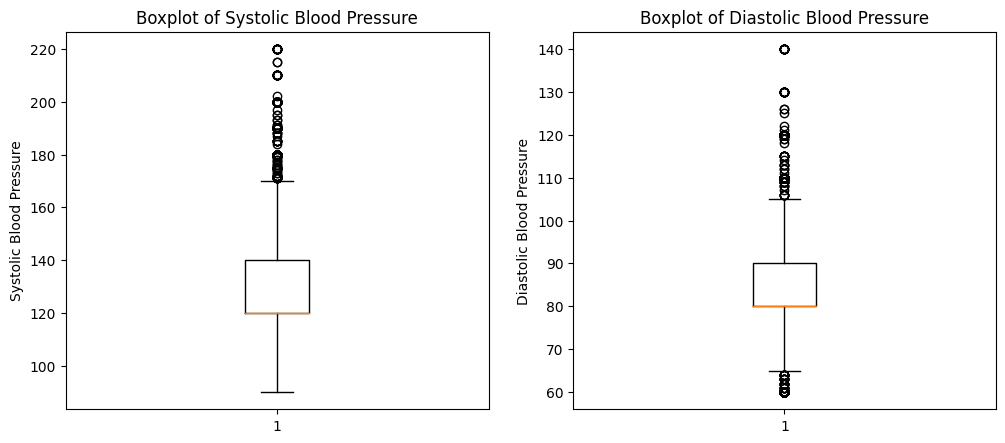

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

for ax, feature, name in zip(axes, ["ap_hi", "ap_lo"], ["Systolic", "Diastolic"]):
    ax.boxplot(df_cardio[feature]);
    ax.set_title(f"Boxplot of {name} Blood Pressure")
    ax.set_ylabel(f"{name} Blood Pressure");

### Creating the Blood Pressure Categories

In [35]:
# Reference: https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable
df_cardio=df_cardio.assign(BP_category=np.nan)
df_cardio.loc[(df_cardio["ap_hi"] < 120) & (df_cardio["ap_lo"] < 80), 
            "BP_category"] = "Healthy"
df_cardio.loc[(df_cardio["ap_hi"] >= 120) & (df_cardio["ap_hi"] < 130) 
            & (df_cardio["ap_lo"] < 80), 
            "BP_category"] = "Elevated"
df_cardio.loc[((df_cardio["ap_hi"] >= 130) & (df_cardio["ap_hi"] < 140)) 
            | ((df_cardio["ap_lo"] >= 80) & (df_cardio["ap_lo"] < 90)), 
            "BP_category"] = "Hypertension Stage 1"
df_cardio.loc[((df_cardio["ap_hi"] >= 140) & (df_cardio["ap_hi"] <= 180)) 
            | ((df_cardio["ap_lo"] >= 90) & (df_cardio["ap_lo"] <= 120)), 
            "BP_category"] = "Hypertension Stage 2"
df_cardio.loc[(df_cardio["ap_hi"] > 180) | (df_cardio["ap_lo"] > 120), 
            "BP_category"] = "Hypertension Crisis"


In [36]:
print(f"Missing values: {df_cardio['BP_category'].isna().sum()}")
df_cardio["BP_category"].value_counts()

Missing values: 0


Hypertension Stage 1    32359
Hypertension Stage 2    23107
Healthy                  9398
Elevated                 3096
Hypertension Crisis       275
Name: BP_category, dtype: int64

## 2.2.0 - Visualiseringar andel sjukdomar
Skapa barplots med en feature mot andelen positiva för hjärt-kärlsjukdom. Exempelvis blodtryckskategorier
mot andel positiva, BMI kategori mot andel positiva mm. Gör dessa plots i en figur med flera subplots.

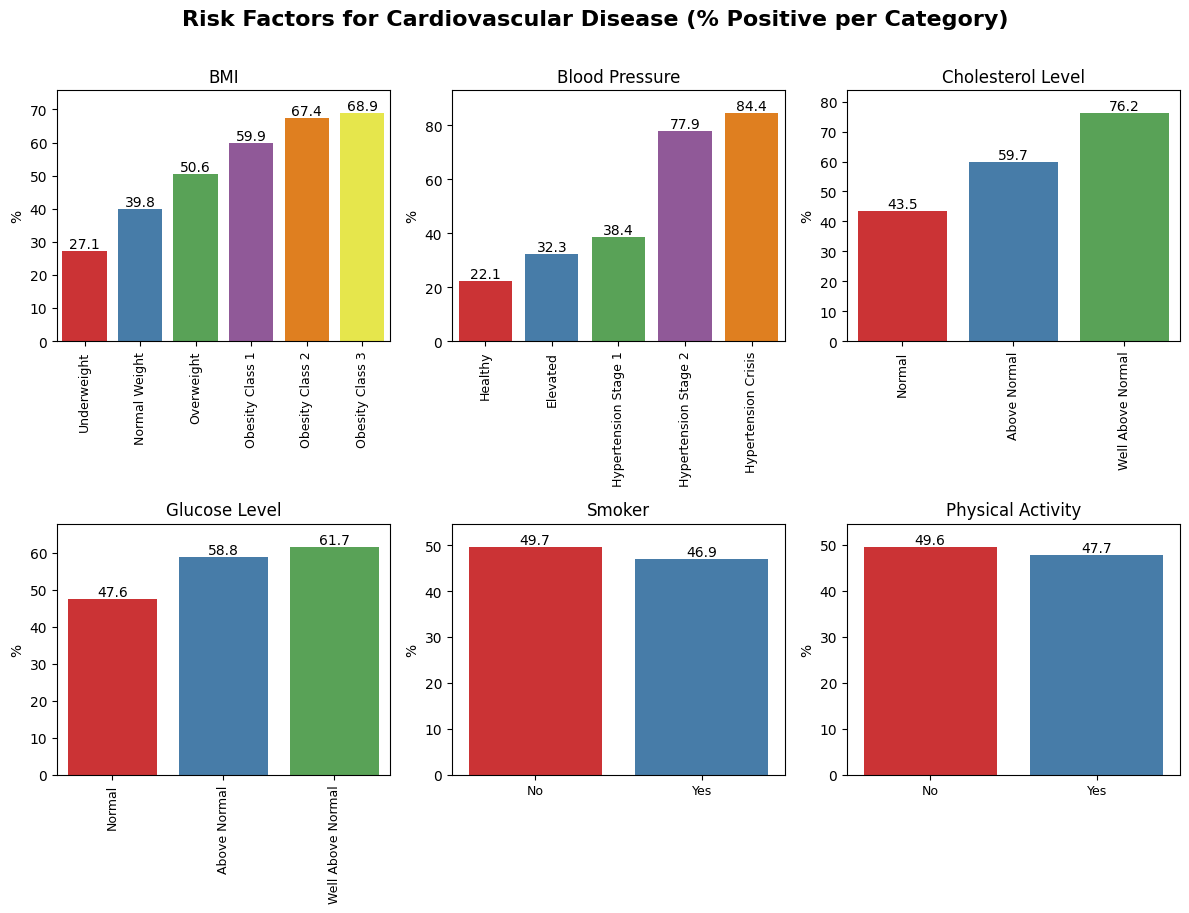

In [48]:
columns = ["BMI_category", "BP_category", "cholesterol", "gluc", "smoke", "alco", "active"]
titles = ["BMI", "Blood Pressure", "Cholesterol Level", "Glucose Level", "Smoker", "Physical Activity"]

fig, axes = plt.subplots(2, 3, figsize=(12, 9), dpi=100)

for ax, column, title, count in zip(axes.flatten(), columns, titles, range(6)):

    # Creates a dataframe with the data for each subplot
    # Calculates the number of cases with cardiovascular disease for each categorical variable in the columns list
    df_category = pd.DataFrame({"Positive":df_cardio["cardio"].groupby(df_cardio[column]).sum(),
                                "Total":df_cardio[column].value_counts()}).reset_index()
    
    df_category = df_category.rename({"index":"Category"}, axis=1)
    df_category["%"] = (df_category["Positive"] / df_category["Total"] * 100).round(1)
    df_category = df_category.sort_values(by="%")
    
    # PLOTTING
    sns.barplot(data = df_category, x="Category", y="%", ax = ax, palette="Set1")
    
    # Ax settings
    ax.set(title=title, xlabel="", ymargin=0.1)
    ax.bar_label(ax.containers[0]) # Sets the value for each bar, Reference: https://stackoverflow.com/questions/68320207/how-to-get-the-label-values-on-a-bar-chat-with-seaborn-on-a-categorical-data

    # Set the tick label for each subplot
    if count <= 1:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size=9)
    elif count == 2 or count == 3:
        ax.set_xticklabels(["Normal", "Above Normal", "Well Above Normal"], rotation=90, size=9)
    else:
        ax.set_xticklabels(["No", "Yes"], size=9)

    #Figure settings
    fig.tight_layout()
    fig.suptitle("Risk Factors for Cardiovascular Disease (% Positive per Category)", y=1.01, fontweight="bold", size=16)

##### Some Thoughts about the Plot

*BMI:*
According to the plot above, people in the underweight group had the lowest risk for cardiovascular disease. This was a bit surprising to me, and not according to previous research. 

*Smoking:*
I also noted that smokers had a lower risk (however, I am not sure if it is statistical significant) for cardiovascular disease than non-smokers. 

## 2.2.1 - Visualiseringar korrelation
Skapa en heatmap av korrelationer och se om du hittar features som är starkt korrelerade, dvs nära 1 eller
features som är starkt negativt korrelerade, dvs nära -1. Kan du förklara varför de kan vara korrelerade?

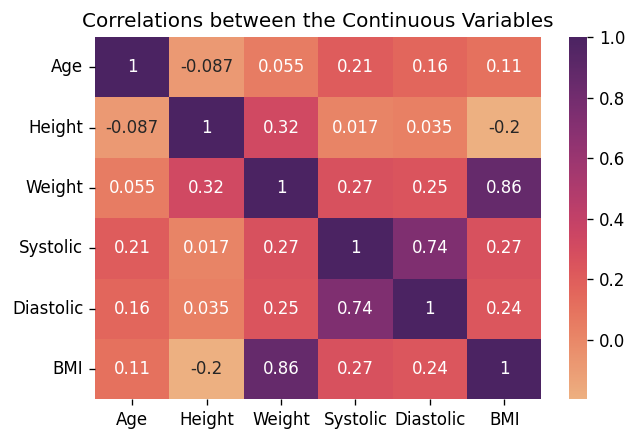

In [37]:
tick_labels = ["Age", "Height", "Weight", "Systolic", "Diastolic", "BMI"]

fig, ax = plt.subplots(dpi=120)
_ = sns.heatmap(df_cardio[["age", "height", "weight", "ap_hi", "ap_lo", "BMI"]].corr(), 
                cmap="flare", 
                annot=True, 
                xticklabels=tick_labels, 
                yticklabels=tick_labels
                )

_ = ax.set_title("Correlations between the Continuous Variables")

In general, correlations are weak. We have a few highly correlated features: 
- Weight and BMI (0.86): makes sense since BMI is calculated from weight. 
- Systolic and Diastolic Blood Pressure (0.73): also makes sense since when one of them increases, the other usually also increases and vice versa.

Interestingly, the correlation between height and weight is only 0.32.

## 2.3 - Skapa två dataset
Skapa en kopia av ditt dataframe. På ena dataframet:
- ta bort följande features: ap_hi, ap_lo, height, weight, BMI
- gör one-hot encoding på BMI-kategori, blodtryckskategori, kön

På andra dataframet:
- ta bort följande features: BMI-kategori, blodtryckskategori, height, weight
- gör one-hot encoding på kön

In addition to this, I also chose to do dummy coding for cholesterol and glucose, since these were coded as 1, 2 and 3, and since some of the models can be sensitive to this. I also drop the id column. 

In [40]:
df_cardio_categorical = pd.get_dummies(df_cardio, columns = ["gender", "BMI_category", "BP_category", "cholesterol", "gluc"], drop_first=True)
df_cardio_categorical = df_cardio_categorical.drop(["id", "height", "weight", "ap_hi", "ap_lo", "BMI"], axis=1)
df_cardio_categorical = df_cardio_categorical.rename({
                                                    "cholesterol_2" : "cholesterol_above_normal",
                                                    "cholesterol_3" : "cholesterol_well_above_normal",
                                                    "gluc_2" : "gluc_above_normal",
                                                    "gluc_3" : "gluc_well_above_normal",
                                                    "gender_2" : "Male",
                                                    "BMI_category_Obesity Class 1" : "BMI_obesity1",
                                                    "BMI_category_Obesity Class 2" : "BMI_obesity2",
                                                    "BMI_category_Obesity Class 3" : "BMI_obesity3",
                                                    "BMI_category_Overweight" : "BMI_overweight",
                                                    "BMI_category_Underweight" : "BMI_underweight",
                                                    "BP_category_Healthy" : "BP_healthy",
                                                    "BP_category_Hypertension Crisis" : "BP_hypertension_crisis",
                                                    "BP_category_Hypertension Stage 1" : "BP_hypertension1",
                                                    "BP_category_Hypertension Stage 2" : "BP_hypertension2",
                                                    }, axis=1)

df_cardio_categorical.head(5)

,age,smoke,alco,active,cardio,Male,BMI_obesity1,BMI_obesity2,BMI_obesity3,BMI_overweight,BMI_underweight,BP_healthy,BP_hypertension_crisis,BP_hypertension1,BP_hypertension2,cholesterol_above_normal,cholesterol_well_above_normal,gluc_above_normal,gluc_well_above_normal
0,18393,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,20228,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0
2,18857,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,17623,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
4,17474,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [41]:
df_cardio_categorical.columns

Index(['age', 'smoke', 'alco', 'active', 'cardio', 'Male', 'BMI_obesity1',
       'BMI_obesity2', 'BMI_obesity3', 'BMI_overweight', 'BMI_underweight',
       'BP_healthy', 'BP_hypertension_crisis', 'BP_hypertension1',
       'BP_hypertension2', 'cholesterol_above_normal',
       'cholesterol_well_above_normal', 'gluc_above_normal',
       'gluc_well_above_normal'],
      dtype='object')

In [42]:
df_cardio_continuous = pd.get_dummies(df_cardio, columns = ["gender", "cholesterol", "gluc"], drop_first=True)
df_cardio_continuous = df_cardio_continuous.rename({
                                                    "gender_2": "Male",
                                                    "cholesterol_2" : "cholesterol_above_normal",
                                                    "cholesterol_3" : "cholesterol_well_above_normal",
                                                    "gluc_2" : "gluc_above_normal",
                                                    "gluc_3" : "gluc_well_above_normal",
                                                    }, axis=1)
df_cardio_continuous = df_cardio_continuous.drop(["id", "BMI_category", "BP_category", "height", "weight"], axis=1)

df_cardio_continuous.head(5)

,age,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,Male,cholesterol_above_normal,cholesterol_well_above_normal,gluc_above_normal,gluc_well_above_normal
0,18393,110,80,0,0,1,0,21.967120,1,0,0,0,0
1,20228,140,90,0,0,1,1,34.927679,0,0,1,0,0
2,18857,130,70,0,0,0,1,23.507805,0,0,1,0,0
3,17623,150,100,0,0,1,1,28.710479,1,0,0,0,0
4,17474,100,60,0,0,0,0,23.011177,0,0,0,0,0


We still have age as a continuous variable in the categorical dataset. I wonder if that can affect the results and I therefore create an entirely categorical dataset, by creating categories from age and then dummy coding them. 

In [43]:
# Creating categorical age
df_cardio_categorical2 = pd.DataFrame.copy(df_cardio_categorical)

df_cardio_categorical2=df_cardio_categorical2.assign(Age_category=np.nan)
df_cardio_categorical2.loc[df_cardio_categorical2["age"]/365 < 40, 
                "Age_category"] = "below_40"
df_cardio_categorical2.loc[(df_cardio_categorical2["age"]/365 >= 40) & (df_cardio_categorical2["age"]/365 < 50), 
                "Age_category"] = "40-50"
df_cardio_categorical2.loc[(df_cardio_categorical2["age"]/365 >= 50) & (df_cardio_categorical2["age"]/365 < 60), 
                "Age_category"] = "50-60"
df_cardio_categorical2.loc[df_cardio_categorical2["age"]/365 >= 60, 
                "Age_category"] = "60_and_above"

print(f"Missing values: {df_cardio_categorical2['Age_category'].isna().sum()}")          
df_cardio_categorical2["Age_category"].value_counts()

Missing values: 0


50-60           34623
40-50           19163
60_and_above    12703
below_40         1746
Name: Age_category, dtype: int64

In [44]:
# Dummy coding age
df_cardio_categorical2 = pd.get_dummies(df_cardio_categorical2, columns = ["Age_category"], drop_first=True)
df_cardio_categorical2 = df_cardio_categorical2.drop(["age"], axis=1)
df_cardio_categorical2 = df_cardio_categorical2.rename({
                                                    "Age_category_50-60" : "Age_50-60",
                                                    "Age_category_60_and_above" : "Age_60_and_above",
                                                    "Age_category_below_40" : "Age_below_40",
                                                   }, axis=1)

df_cardio_categorical2.head(5)

,smoke,alco,active,cardio,Male,BMI_obesity1,BMI_obesity2,BMI_obesity3,BMI_overweight,BMI_underweight,...,BP_hypertension_crisis,BP_hypertension1,BP_hypertension2,cholesterol_above_normal,cholesterol_well_above_normal,gluc_above_normal,gluc_well_above_normal,Age_50-60,Age_60_and_above,Age_below_40
0,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,1,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,0,0,1,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.4 - Välja modell
Välj 3-5 maskininlärningsmodeller, gärna så olika som möjligt. För varje dataset som vi skapade i uppgift 2.3
gör följande:
- train|validation|test split
- skala datasetet med feature standardization och normalization
- definiera hyperparametrar (param_grids) att testa för varje modell
- använd GridSearchCV() och välja lämplig evalueringsmetric
- gör prediction på valideringsdata
- beräkna och spara evaluation score för ditt valda metric
- checka bästa parametrarna för respektive modell

Vilket dataset väljer du och vilken modell väljer du? Använd den modellen du valt och träna på hela
träningsdatan.

### Step 1. Split the Data

In [45]:
def train_val_test_split(X:pd.DataFrame, y:pd.DataFrame) -> tuple[pd.DataFrame]:
    """
    Randomly splits the data into train, validation and test. 
    
    Parameters
    ----------
    X : pd.DataFrame
        The X-data
    y : pd.DataFrame
        The y-data

    Returns
    -------
    X_train, X_val, X_test : pd.DataFrame
        The X data splitted into train, validation and test. 
    y_train, y_val, y_test : pd.DataFrame
        The y data splitted into train, validation and test.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [46]:
#Splits the data into X and y
X_cat, y_cat = df_cardio_categorical.drop(["cardio"], axis=1), df_cardio_categorical["cardio"]
X_cont, y_cont = df_cardio_continuous.drop(["cardio"], axis=1), df_cardio_continuous["cardio"]
X_cat2, y_cat2 = df_cardio_categorical2.drop(["cardio"], axis=1), df_cardio_categorical2["cardio"]

In [47]:
X_train_cat, X_val_cat, X_test_cat, y_train_cat, y_val_cat, y_test_cat = train_val_test_split(X_cat, y_cat)
X_train_cont, X_val_cont, X_test_cont, y_train_cont, y_val_cont, y_test_cont = train_val_test_split(X_cont, y_cont)
X_train_cat2, X_val_cat2, X_test_cat2, y_train_cat2, y_val_cat2, y_test_cat2 = train_val_test_split(X_cat2, y_cat2)

print(X_train_cat.shape, y_train_cat.shape, X_val_cat.shape, y_val_cat.shape, X_test_cat.shape, y_test_cat.shape)
print(X_train_cont.shape, y_train_cont.shape, X_val_cont.shape, y_val_cont.shape, X_test_cont.shape, y_test_cont.shape)
print(X_train_cat2.shape, y_train_cat2.shape, X_val_cat2.shape, y_val_cat2.shape, X_test_cat2.shape, y_test_cat2.shape)

(47764, 18) (47764,) (10235, 18) (10235,) (10236, 18) (10236,)
(47764, 12) (47764,) (10235, 12) (10235,) (10236, 12) (10236,)
(47764, 20) (47764,) (10235, 20) (10235,) (10236, 20) (10236,)


Below I create an even smaller dataset to tune the hyperparameters with. This reduced dataset is 10% of the training data. I do this because some of the models (for example SVC) ran for several hours when doing cross-validation. 

In [48]:
X_train_cont_reduced, _ , y_train_cont_reduced, _ = train_test_split(X_train_cont, y_train_cont, test_size = 0.9, random_state=42)
X_train_cat_reduced, _ , y_train_cat_reduced, _ = train_test_split(X_train_cat, y_train_cat, test_size = 0.9, random_state=42)
X_train_cat2_reduced, _ , y_train_cat2_reduced, _ = train_test_split(X_train_cat2, y_train_cat2, test_size = 0.9, random_state=42)

print(X_train_cont_reduced.shape, y_train_cont_reduced.shape)
print(X_train_cat_reduced.shape, y_train_cat_reduced.shape)
print(X_train_cat2_reduced.shape, y_train_cat2_reduced.shape)

(4776, 12) (4776,)
(4776, 18) (4776,)
(4776, 20) (4776,)


### 2. Scale the Data (to use when running the full models)

In [49]:
# Instaniate scanner objects
scaler_norm_cont = MinMaxScaler()
scaler_norm_cat = MinMaxScaler()
scaler_norm_cat2 = MinMaxScaler()
scaler_standard_cont = StandardScaler()
scaler_standard_cat = StandardScaler()
scaler_standard_cat2 = StandardScaler()

# Standardise/normalise the X_train 
norm_X_train_cont = scaler_norm_cont.fit_transform(X_train_cont)
norm_X_train_cat = scaler_norm_cat.fit_transform(X_train_cat)
norm_X_train_cat2 = scaler_norm_cat2.fit_transform(X_train_cat2)
stand_X_train_cont = scaler_standard_cont.fit_transform(X_train_cont)
stand_X_train_cat = scaler_standard_cat.fit_transform(X_train_cat)
stand_X_train_cat2 = scaler_standard_cat2.fit_transform(X_train_cat2)

# Standardise/normalise the X_val 
norm_X_val_cont = scaler_norm_cont.transform(X_val_cont)
norm_X_val_cat = scaler_norm_cat.transform(X_val_cat)
norm_X_val_cat2 = scaler_norm_cat2.transform(X_val_cat2)
stand_X_val_cont = scaler_standard_cont.transform(X_val_cont)
stand_X_val_cat = scaler_standard_cat.transform(X_val_cat)
stand_X_val_cat2 = scaler_standard_cat2.transform(X_val_cat2)

print(f"Normalised X-train Continuous: min: {norm_X_train_cont.min().round(3)}, max: {norm_X_train_cont.max().round(3)}")
print(f"Standardised X-train Continuous: mean: {stand_X_train_cont.mean().round(3)}, std: {stand_X_train_cont.std().round(3)}")
print(f"Normalised X-train Categorical: min: {norm_X_train_cat.min().round(3)}, max: {norm_X_train_cat.max().round(3)}")
print(f"Standardised X-train Categorical: mean: {stand_X_train_cat.mean().round(3)}, std: {stand_X_train_cat.std().round(3)}")
print(f"Normalised X-train Categorical 2: min: {norm_X_train_cat2.min().round(3)}, max: {norm_X_train_cat2.max().round(3)}")
print(f"Standardised X-train Categorical 2: mean: {stand_X_train_cat2.mean().round(3)}, std: {stand_X_train_cat2.std().round(3)}")

Normalised X-train Continuous: min: 0.0, max: 1.0
Standardised X-train Continuous: mean: 0.0, std: 1.0
Normalised X-train Categorical: min: 0.0, max: 1.0
Standardised X-train Categorical: mean: 0.0, std: 1.0
Normalised X-train Categorical 2: min: 0.0, max: 1.0
Standardised X-train Categorical 2: mean: 0.0, std: 1.0


### Step 3. Find Hyperparameters and Train the Models

Below I will create pipelines for the following models:

- Logistic Regression
- K-Nearest Neighbour
- Support Vector Classifier
- Random Forest Classifier

I will use recall as the evaluation metrics. This is because I would like a low number of false-negatives (where we predicted that the patient does not have cardiovascular disese, while in fact she/he has). 

In [591]:
# Some of the models gives warnings. I disable these warnings, since I am aware of them. 
# Conversion Warning: For GridSearchCV, logistic regression (it takes too much time to let it converge entirely)
# Convergence Warning: When running KNN using jaccard metric (see below)
# Reference: https://docs.python.org/3/library/warnings.html#temporarily-suppressing-warnings

def fxn_conversion():
    warnings.warn("DataConversionWarning", DataConversionWarning)

def fxn_convergence():
    warnings.warn("ConvergenceWarning", ConvergenceWarning)

#### Logistic Regression - Find Hyperparameters

In [521]:
pipeline_logistic_cont = Pipeline([
                            ("scaler", None),
							("poly_features", PolynomialFeatures()),
                            ("log_reg", LogisticRegression())
])

pipeline_logistic_cat = Pipeline([
                            ("scaler", None),
                            ("log_reg", LogisticRegression())
])

param_grid_logistic_cont = {
						"scaler" : [StandardScaler(), MinMaxScaler()],
						"poly_features__degree" : [1, 2, 3],
						"poly_features__include_bias" : [False],
						"log_reg__solver" : ["saga"], # I choose saga because it is faster on larger datasets and since it can use all penalties
						"log_reg__penalty" : ["l1", "l2", "elastic_net"],
						"log_reg__C" : [100, 10, 1.0, 0.1, 0.01], 
						"log_reg__max_iter" : [300]
}

param_grid_logistic_cat = {
						"scaler" : [StandardScaler(), MinMaxScaler()],
						"log_reg__solver" : ["saga"], 
						"log_reg__penalty" : ["l1", "l2", "elastic_net"],
						"log_reg__C" : [100, 10, 1.0, 0.1, 0.01], 
						"log_reg__max_iter" : [300]
}

CV_results_logistic_cont = GridSearchCV(estimator=pipeline_logistic_cont, param_grid=param_grid_logistic_cont, cv=5, scoring="recall", verbose=1)
CV_results_logistic_cat = GridSearchCV(estimator=pipeline_logistic_cat, param_grid=param_grid_logistic_cat, cv=5, scoring="recall", verbose=1)
CV_results_logistic_cat2 = GridSearchCV(estimator=pipeline_logistic_cat, param_grid=param_grid_logistic_cat, cv=5, scoring="recall", verbose=1)

In [522]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn_convergence()
    CV_results_logistic_cont.fit(X_train_cont_reduced, y_train_cont_reduced)
    CV_results_logistic_cat.fit(X_train_cat_reduced, y_train_cat_reduced)
    CV_results_logistic_cat2.fit(X_train_cat2_reduced, y_train_cat2_reduced)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [558]:
print(f"Best Score for Continouos Data: {CV_results_logistic_cont.best_score_:.2f} using {CV_results_logistic_cont.best_params_}")
print(f"Best Score for Categorical Data: {CV_results_logistic_cat.best_score_:.2f} using {CV_results_logistic_cat.best_params_}")
print(f"Best Score for Categorical Data 2: {CV_results_logistic_cat2.best_score_:.2f} using {CV_results_logistic_cat2.best_params_}")

Best Score for Continouos Data: 0.68 using {'log_reg__C': 0.01, 'log_reg__max_iter': 300, 'log_reg__penalty': 'l2', 'log_reg__solver': 'saga', 'poly_features__degree': 2, 'poly_features__include_bias': False, 'scaler': StandardScaler()}
Best Score for Categorical Data: 0.65 using {'log_reg__C': 0.01, 'log_reg__max_iter': 300, 'log_reg__penalty': 'l2', 'log_reg__solver': 'saga', 'scaler': StandardScaler()}
Best Score for Categorical Data 2: 0.65 using {'log_reg__C': 10, 'log_reg__max_iter': 300, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga', 'scaler': MinMaxScaler()}


**Best Recall for Continuous Data: 0.68**

using:
- 'log_reg__C' : 0.01
- 'log_reg__max_iter' : 300
- 'log_reg__penalty' : 'l2'
- 'log_reg__solver' : 'saga'
- 'poly_features__degree' : 2
- 'poly_features__include_bias' : False
- 'scaler' : StandardScaler()

**Best Recall for Categorical Data: 0.65**

using:
- 'log_reg__C': 0.01
- 'log_reg__max_iter': 300
- 'log_reg__penalty': 'l2'
- 'log_reg__solver': 'saga'
- 'scaler': StandardScaler()

**Best Recall for Categorical Data 2 (entirely binary): 0.65**

using:
- 'log_reg__C': 10
- 'log_reg__max_iter': 300
- 'log_reg__penalty': 'l1'
- 'log_reg__solver': 'saga'
- 'scaler': MinMaxScaler()

#### Logistic Regression - Train the Models

In [616]:
# CONTINUOUS DATA

# Create polynomial features
polynomial_features = PolynomialFeatures(degree = 2, include_bias=False)
poly_X_train_cont = polynomial_features.fit_transform(stand_X_train_cont)

# Create the model and fit the data to it
model_logistic_cont = LogisticRegression(C=0.01, solver="saga", penalty="l2", max_iter=1000) # Now increasing the number of iterations
model_logistic_cont.fit(poly_X_train_cont, y_train_cont)

# CATEGORICAL DATA

# Create the model and fit the data to it
model_logistic_cat = LogisticRegression(C=0.01, solver="saga", penalty="l2", max_iter=1000) # Now increasing the number of iterations
model_logistic_cat.fit(stand_X_train_cat, y_train_cat)

# CATEGORICAL DATA 2

# Create the model and fit the data to it
model_logistic_cat2 = LogisticRegression(C=10, solver="saga", penalty="l1", max_iter=1000) # Now increasing the number of iterations
model_logistic_cat2.fit(norm_X_train_cat2, y_train_cat2)

LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='saga')

#### K-Nearest Neighbours - Find Hyperparameters

In [584]:
pipeline_KNN = Pipeline([
                        ('scaler', None),
                        ('knn', KNeighborsClassifier())
])

param_grid_KNN_cont = {
                "scaler" : [StandardScaler(), MinMaxScaler()],
                "knn__n_neighbors" : range(1, 11),
                "knn__metric" : ["euclidean", "manhattan"]
} 

param_grid_KNN_cat = {
                "scaler" : [StandardScaler(), MinMaxScaler()],
                "knn__n_neighbors" : range(1, 11),
                "knn__metric" : ["euclidean", "manhattan"]
} 

param_grid_KNN_cat2 = {
                "scaler" : [StandardScaler(), MinMaxScaler()],
                "knn__n_neighbors" : range(1, 11),
                "knn__metric" : ["jaccard", "matching"]
} 

CV_results_KNN_cont = GridSearchCV(estimator=pipeline_KNN, param_grid=param_grid_KNN_cont, cv=5, scoring="recall", verbose=1)
CV_results_KNN_cat = GridSearchCV(estimator=pipeline_KNN, param_grid=param_grid_KNN_cat, cv=5, scoring="recall", verbose=1)
CV_results_KNN_cat2 = GridSearchCV(estimator=pipeline_KNN, param_grid=param_grid_KNN_cat2, cv=5, scoring="accuracy", verbose=1) # Set this to accuracy, becuase it does not work well with recall

I choose to calculate accuracy, rather than recall, when running GridSearchCV for the third, entirely binary, dataset. If I do not do this it will return a perfect recall, and when I run the model on the validation data it will classify all observations as cardiovascular disease. This gives a perfect recall, but an accuracy as good as flipping a coin. 

In [585]:
CV_results_KNN_cont.fit(X_train_cont_reduced, y_train_cont_reduced)
CV_results_KNN_cat.fit(X_train_cat_reduced, y_train_cat_reduced)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', None),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': range(1, 11),
                         'scaler': [StandardScaler(), MinMaxScaler()]},
             scoring='recall', verbose=1)

In [586]:
# This code gives a DataConversionWarning, that the jaccard metrics converts the data to dummy variables

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn_conversion()   
    CV_results_KNN_cat2.fit(X_train_cat2_reduced, y_train_cat2_reduced)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [588]:
print(f"Best Score for Categorical Data: {CV_results_KNN_cat.best_score_:.2f} using {CV_results_KNN_cat.best_params_}")
print(f"Best Score for Categorical Data: {CV_results_KNN_cat.best_score_:.2f} using {CV_results_KNN_cat.best_params_}")
print(f"Best Score for Categorical Data 2: {CV_results_KNN_cat2.best_score_:.2f} using {CV_results_KNN_cat2.best_params_}")

**Best Recall for Continuous Data: 0.70**

using:
- 'knn__metric': 'euclidean', 
- 'knn__n_neighbors': 7, 
- 'scaler': StandardScaler()

**Best Recall for Categorical Data: 0.70**

using:
- 'knn__metric': 'euclidean'
- 'knn__n_neighbors': 7
- 'scaler': StandardScaler()

**Best Accuracy for Categorical Data 2 (entirely binary): 0.69**

using:
- 'knn__metric': 'jaccard'
- 'knn__n_neighbors': 9
- 'scaler': MinMaxScaler()


#### K-Nearest Neighbours - Train the Models

In [589]:
# CONTINUOUS DATA
# Create the model and fit the data to it
model_KNN_cont = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
model_KNN_cont.fit(stand_X_train_cont, y_train_cont)

# CATEGORICAL DATA
# Create the model and fit the data to it
model_KNN_cat = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
model_KNN_cat.fit(stand_X_train_cat, y_train_cat)

# CATEGORICAL DATA 2
# Create the model and fit the data to it
model_KNN_cat2 = KNeighborsClassifier(n_neighbors=9, metric="jaccard")
model_KNN_cat2.fit(norm_X_train_cat2, y_train_cat2)

KNeighborsClassifier(metric='jaccard', n_neighbors=9)

#### Support Vector Classifier - Find Hyperparameters

In [612]:
pipeline_SVC = Pipeline([
                        ('scaler', None),
                        ('svc', SVC())
])

param_grid_SVC = {
                "scaler" : [StandardScaler(), MinMaxScaler()],
                "svc__C" : [0.001, 0.01, 0.1, 1, 10, 100],
                "svc__gamma" : [0.001, 0.01, 0.1, 1, 10, 100],
                "svc__kernel" : ["rbf"], 
} 

# I use accuracy as a classifier, since it does not work with recall
CV_results_SVC_cont = GridSearchCV(estimator=pipeline_SVC, param_grid=param_grid_SVC, cv=5, scoring="accuracy", verbose=1)
CV_results_SVC_cat = GridSearchCV(estimator=pipeline_SVC, param_grid=param_grid_SVC, cv=5, scoring="accuracy", verbose=1)
CV_results_SVC_cat2 = GridSearchCV(estimator=pipeline_SVC, param_grid=param_grid_SVC, cv=5, scoring="accuracy", verbose=1)

SVC does not work very well with recall. Using the hyperparameters from GridSearchCV on the validation data, the model classifies all of the observations as having cardiovascular disease. 

In [593]:
CV_results_SVC_cont.fit(X_train_cont_reduced, y_train_cont_reduced)
CV_results_SVC_cat.fit(X_train_cat_reduced, y_train_cat_reduced)
CV_results_SVC_cat2.fit(X_train_cat2_reduced, y_train_cat2_reduced)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('scaler', None), ('svc', SVC())]),
             param_grid={'scaler': [StandardScaler(), MinMaxScaler()],
                         'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'svc__kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [594]:
print(f"Best Score for Continuous Data: {CV_results_SVC_cont.best_score_:.2f} using {CV_results_SVC_cont.best_params_}")
print(f"Best Score for Categorical Data: {CV_results_SVC_cat.best_score_:.2f} using {CV_results_SVC_cat.best_params_}")
print(f"Best Score for Categorical Data 2: {CV_results_SVC_cat2.best_score_:.2f} using {CV_results_SVC_cat2.best_params_}")

Best Score for Continuous Data: 0.72 using {'scaler': StandardScaler(), 'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best Score for Categorical Data: 0.72 using {'scaler': MinMaxScaler(), 'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Best Score for Categorical Data 2: 0.72 using {'scaler': MinMaxScaler(), 'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


**Best Accuracy for Continuous Data: 0.72**

using:
- 'scaler': StandardScaler()
- 'svc__C': 100
- 'svc__gamma': 0.001
- 'svc__kernel': 'rbf'
- 'svc__max_iter': 1000}

**Best Accuracy for Categorical Data: 0.72**

using: 
- 'scaler': MinMaxScaler()
- 'svc__C': 10
- 'svc__gamma': 0.1
- 'svc__kernel': 'rbf'
- 'svc__max_iter': 1000}

**Best Acuracy for Categorical Data 2 (entirely binary): 0.72**

using: 
- 'scaler': MinMaxScaler()
- 'svc__C': 1
- 'svc__gamma': 0.1
- 'svc__kernel': 'rbf'
- 'svc__max_iter': 1000}

#### Support Vector Classifier - Train the Models

In [595]:
# CONTINUOUS DATA

# Create the model and fit the data to it
model_SVC_cont = SVC(kernel="rbf", C=100, gamma=0.001)
model_SVC_cont.fit(stand_X_train_cont, y_train_cont)

# CATEGORICAL DATA

# Create the model and fit the data to it
model_SVC_cat = SVC(kernel="rbf", C=10, gamma=0.1)
model_SVC_cat.fit(norm_X_train_cat, y_train_cat)

# Create the model and fit the data to it
model_SVC_cat2 = SVC(kernel="rbf", C=1, gamma=0.1)
model_SVC_cat2.fit(norm_X_train_cat2, y_train_cat2)

SVC(C=1, gamma=0.1)

#### Random Forest Classifier - Find Hyperparameters

In [598]:
pipeline_RFC = Pipeline([
                        ('scaler', StandardScaler()),
                        ('random_forest', RandomForestClassifier())
])

param_grid_RFC = {
                "scaler": [StandardScaler(), MinMaxScaler()],
                "random_forest__n_estimators" : [300],
                "random_forest__criterion" : ["gini", "entropy"],
                "random_forest__max_features" : [None, "sqrt", 0.2],
} 

CV_results_RFC_cont = GridSearchCV(estimator=pipeline_RFC, param_grid=param_grid_RFC, cv=5, scoring="recall", verbose=1)
CV_results_RFC_cat = GridSearchCV(estimator=pipeline_RFC, param_grid=param_grid_RFC, cv=5, scoring="recall", verbose=1)
CV_results_RFC_cat2 = GridSearchCV(estimator=pipeline_RFC, param_grid=param_grid_RFC, cv=5, scoring="recall", verbose=1)

In [599]:
CV_results_RFC_cont.fit(X_train_cont_reduced, y_train_cont_reduced)
CV_results_RFC_cat.fit(X_train_cat_reduced, y_train_cat_reduced)
CV_results_RFC_cat2.fit(X_train_cat2_reduced, y_train_cat2_reduced)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('random_forest',
                                        RandomForestClassifier())]),
             param_grid={'random_forest__criterion': ['gini', 'entropy'],
                         'random_forest__max_features': [None, 'sqrt', 0.2],
                         'random_forest__n_estimators': [300],
                         'scaler': [StandardScaler(), MinMaxScaler()]},
             scoring='recall', verbose=1)

In [600]:
print(f"Best Score for Continuous Data: {CV_results_RFC_cont.best_score_:.2f} using {CV_results_RFC_cont.best_params_}")
print(f"Best Score for Categorical Data: {CV_results_RFC_cat.best_score_:.2f} using {CV_results_RFC_cat.best_params_}")
print(f"Best Score for Categorical Data 2: {CV_results_RFC_cat.best_score_:.2f} using {CV_results_RFC_cat.best_params_}")

Best Score for Continuous Data: 0.68 using {'random_forest__criterion': 'entropy', 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 300, 'scaler': MinMaxScaler()}
Best Score for Categorical Data: 0.66 using {'random_forest__criterion': 'gini', 'random_forest__max_features': None, 'random_forest__n_estimators': 300, 'scaler': StandardScaler()}
Best Score for Categorical Data 2: 0.66 using {'random_forest__criterion': 'gini', 'random_forest__max_features': None, 'random_forest__n_estimators': 300, 'scaler': StandardScaler()}


**Best Recall for Continuous Data: 0.68**

using: 
- 'random_forest__criterion': 'entropy'
- 'random_forest__max_features': sqrt
- 'random_forest__n_estimators': 300
- 'scaler': MinMaxScaler()

**Best Score for Categorical Data: 0.66** 

using: 
- 'random_forest__criterion': 'gini'
- 'random_forest__max_features': None
- 'random_forest__n_estimators': 300
- 'scaler': StandardScaler()

**Best Score for Categorical Data 2 (entirely binary): 0.66**

using: 
- 'random_forest__criterion': 'gini'
- 'random_forest__max_features': None
- 'random_forest__n_estimators': 300
- 'scaler': StandardScaler()

#### Random Forest Classifier - Train the Models

In [603]:
# CONTINUOUS DATA
# Create the model and fit the data to it
model_RFC_cont = RandomForestClassifier(criterion="entropy", max_features="sqrt", n_estimators=1000) #Increasing the number of trees for the fit (it is unusal for random forest to overfit)
model_RFC_cont.fit(norm_X_train_cont, y_train_cont)

# CATEGORICAL DATA
# Create the model and fit the data to it
model_RFC_cat = RandomForestClassifier(criterion="gini", max_features=None, n_estimators=1000)
model_RFC_cat.fit(stand_X_train_cat, y_train_cat)

# Create the model and fit the data to it
model_RFC_cat2 = RandomForestClassifier(criterion="gini", max_features=None, n_estimators=1000)
model_RFC_cat2.fit(stand_X_train_cat2, y_train_cat)

RandomForestClassifier(max_features=None, n_estimators=1000)

### Step 4. Prediction on Validation Data

#### Logistic Regression

In [55]:
def print_and_plot_results(y_true:pd.Series, y_pred:np.ndarray, model_name:str, dataset_name:str=None, confusion_mat:bool=False) -> None:
    """
    Prints a classification report and plots a confusion matrix. 
    
    Parameters
    ----------
    y_true : pd.Series
        The real y-values.
    y_pred : np.ndarray
        The predicted y-values.
    model_name : str
        The name of the model.
    dataset_name : str
        The name of the dataset used.
    confusion_mat : bool
        If True: 
            Plots a confusion matrix.
    """

    classification_report_ = classification_report(y_true, y_pred)

    if confusion_mat:
        print(f"Classification Report for {model_name}: \n {classification_report_}")
        cm = confusion_matrix(y_true, y_pred)
        cm_fig = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot()
        _ = cm_fig.ax_.set(title=f"Results for {model_name} on Test Data")
    else:
        print(f"Classification Report for {model_name} - {dataset_name}: \n {classification_report_}")

In [701]:
# Create polynomial features for the validation data
polynomial_features = PolynomialFeatures(degree = 2, include_bias=False)
poly_X_val_cont = polynomial_features.fit_transform(stand_X_val_cont)

# Predict on validation data
y_pred_logistic_cont = model_logistic_cont.predict(poly_X_val_cont)
y_pred_logistic_cat = model_logistic_cat.predict(stand_X_val_cat)
y_pred_logistic_cat2 = model_logistic_cat2.predict(norm_X_val_cat2)

In [694]:
for y_true, y_pred, dataset_name in zip([y_val_cont, y_val_cat, y_val_cat2], 
                                    [y_pred_logistic_cont, y_pred_logistic_cat, y_pred_logistic_cat2], 
                                    ["Continuous Data", "Categorical Data", "Categorical Data (entirely binary)"]):
    print_and_plot_results(y_true, y_pred, "Logistic Regression", dataset_name)

Classification Report for Logistic Regression - Continuous Data: 
               precision    recall  f1-score   support

           0       0.73      0.76      0.74      5236
           1       0.74      0.70      0.72      4999

    accuracy                           0.73     10235
   macro avg       0.73      0.73      0.73     10235
weighted avg       0.73      0.73      0.73     10235

Classification Report for Logistic Regression - Categorical Data: 
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      5236
           1       0.75      0.65      0.70      4999

    accuracy                           0.72     10235
   macro avg       0.73      0.72      0.72     10235
weighted avg       0.73      0.72      0.72     10235

Classification Report for Logistic Regression - Categorical Data (entirely binary): 
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      5236
           1    

#### K-Nearest Neighbours

In [699]:
# Predict on validation data
y_pred_KNN_cont = model_KNN_cont.predict(stand_X_val_cont)
y_pred_KNN_cat = model_KNN_cat.predict(stand_X_val_cat)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn_conversion() 
    y_pred_KNN_cat2 = model_KNN_cat2.predict(norm_X_val_cat2)

In [685]:
for y_true, y_pred, dataset_name in zip([y_val_cont, y_val_cat, y_val_cat2], 
                                    [y_pred_KNN_cont, y_pred_KNN_cat, y_pred_KNN_cat2], 
                                    ["Continuous Data", "Categorical Data", "Categorical Data (entirely binary)"]):
    print_and_plot_results(y_true, y_pred, "KNN", dataset_name)

Classification Report for KNN - Continuous Data: 
               precision    recall  f1-score   support

           0       0.70      0.73      0.71      5236
           1       0.70      0.68      0.69      4999

    accuracy                           0.70     10235
   macro avg       0.70      0.70      0.70     10235
weighted avg       0.70      0.70      0.70     10235

Classification Report for KNN - Categorical Data: 
               precision    recall  f1-score   support

           0       0.70      0.71      0.70      5236
           1       0.69      0.68      0.68      4999

    accuracy                           0.69     10235
   macro avg       0.69      0.69      0.69     10235
weighted avg       0.69      0.69      0.69     10235

Classification Report for KNN - Categorical Data (entirely binary): 
               precision    recall  f1-score   support

           0       0.72      0.67      0.69      5236
           1       0.68      0.72      0.70      4999

    accur

#### Support Vector Classifier

In [698]:
# Predict on validation data
y_pred_SVC_cont = model_SVC_cont.predict(stand_X_val_cont)
y_pred_SVC_cat = model_SVC_cat.predict(norm_X_val_cat)
y_pred_SVC_cat2 = model_SVC_cat2.predict(norm_X_val_cat2)

In [686]:
for y_true, y_pred, dataset_name in zip([y_val_cont, y_val_cat, y_val_cat2], 
                                    [y_pred_SVC_cont, y_pred_SVC_cat, y_pred_SVC_cat2], 
                                    ["Continuous Data", "Categorical Data", "Categorical Data (entirely binary)"]):
    print_and_plot_results(y_true, y_pred, "SVC", dataset_name)

Classification Report for SVC - Continuous Data: 
               precision    recall  f1-score   support

           0       0.71      0.81      0.75      5236
           1       0.76      0.65      0.70      4999

    accuracy                           0.73     10235
   macro avg       0.74      0.73      0.73     10235
weighted avg       0.74      0.73      0.73     10235

Classification Report for SVC - Categorical Data: 
               precision    recall  f1-score   support

           0       0.69      0.81      0.75      5236
           1       0.76      0.63      0.69      4999

    accuracy                           0.72     10235
   macro avg       0.73      0.72      0.72     10235
weighted avg       0.73      0.72      0.72     10235

Classification Report for SVC - Categorical Data (entirely binary): 
               precision    recall  f1-score   support

           0       0.72      0.76      0.74      5236
           1       0.73      0.68      0.71      4999

    accur

#### Random Forest

In [697]:
# Predict on validation data
y_pred_RFC_cont = model_RFC_cont.predict(norm_X_val_cont)
y_pred_RFC_cat = model_RFC_cat.predict(stand_X_val_cat)
y_pred_RFC_cat2 = model_RFC_cat2.predict(stand_X_val_cat2)

In [687]:
for y_true, y_pred, dataset_name in zip([y_val_cont, y_val_cat, y_val_cat2], 
                                    [y_pred_RFC_cont, y_pred_RFC_cat, y_pred_RFC_cat2], 
                                    ["Continuous Data", "Categorical Data", "Categorical Data (entirely binary)"]):
    print_and_plot_results(y_true, y_pred, "RFC", dataset_name)

Classification Report for RFC - Continuous Data: 
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      5236
           1       0.71      0.69      0.70      4999

    accuracy                           0.71     10235
   macro avg       0.71      0.71      0.71     10235
weighted avg       0.71      0.71      0.71     10235

Classification Report for RFC - Categorical Data: 
               precision    recall  f1-score   support

           0       0.67      0.66      0.66      5236
           1       0.65      0.65      0.65      4999

    accuracy                           0.66     10235
   macro avg       0.66      0.66      0.66     10235
weighted avg       0.66      0.66      0.66     10235

Classification Report for RFC - Categorical Data (entirely binary): 
               precision    recall  f1-score   support

           0       0.71      0.76      0.73      5236
           1       0.73      0.68      0.70      4999

    accur

#### Summary of the Results

| **Model**                 | **Dataset**     |**Recall for Positive**| **Accuracy** | 
|---------------------------|-----------------|-----------------------|--------------|
| Logistic Regression       | Continuous      | <span style="color:green">**0.70**</span>                  | <span style="color:green">**0.73**</span>         |
| K-Nearest Neighbours      | Continuous      | 0.68                  | 0.70         |
| Support Vector Classifier | Continuous      | 0.65                  | 0.73         |
| Random Forest Classifier  | Continuous      | 0.69                  | 0.71         |
| Logistic Regression       | Categorical     | 0.65                  | 0.72         |
| K-Nearest Neighbours      | Categorical     | 0.68                  | 0.69         |
| Support Vector Classifier | Categorical     | 0.63                  | 0.72         |
| Random Forest Classifier  | Categorical     | 0.65                  | 0.66         |
| Logistic Regression       | Categorical 2   | 0.65                  | 0.72         |
| K-Nearest Neighbours      | Categorical 2   | <span style="color:green">**0.72**</span>                  | 0.69         |
| Support Vector Classifier | Categorical 2   | 0.68                  | 0.72         |
| Random Forest Classifier  | Categorical 2   | 0.68                  | 0.72         |

Looking at the results above, we can see that the continuous data and the categorical data (with age dummy coded) perform quite similar in general (although not on the same models). 

My goal is to choose a model with high recall, that is a model that has few false negatives (i.e. the model classifies an observation as not having cardiovascular disease, while in fact the observation is positive). However, the model could solve the classification problem by classifying all of the data points as positive for cardiovascular disease. This would lead to an accuracy of about 50% in our case (since the dataset is balanced). In a more practical sense, this would lead to a lot of extra work for doctors, as well as people taking heart medicine even if they do not need it. We therefore also want a relatively high accuracy (which in the case of balanced datasets is a good measure).

From the table below, we can see that logistic regression performs better than K-Nearest Neighbours on all of the metrics, except recall. However, recall only differs with .02. Furthermore, logistic regression performs more evenly than K-Nearest Neighbours. I am a bit afraid that K-Nearest Neighbours might have overfitted, and I therefore decide to continue with logistic regression. 

##### Comparison Between the Best Models

| **Model**            | **Dataset**   | **Recall for Positive** | **Accuracy** | **f1 for Positive** | **Precision for Positive** |
-----------------------|---------------|-------------------------|--------------|---------------------|--------------------------|
| Logistic Regression  | Continuous    | 0.70                    | 0.73         | 0.72                | 0.74                     |
| K-Nearest Neigbours  | Categorical 2 | 0.72                    | 0.69         | 0.70                | 0.68                     |

Since there is not a lot of difference in performance between the continuous data and the categorical (entirely binary) data, I proceed with the continuous data. This is partly due to practical reasons, since the logistic regression model also performed best on this. 

Worth noting, is that the entirely binary data (where I had also created categories out of age and dummy coded them) did perform better than the "categorical" data (where the only difference is that age is continuous). 

| | Logistic Regression | K-Nearest Neighbours | Support Vector Classifier | Random Forest Classifier |
|-------------------------------|---------------------|----------------------|------------------------|--------------------------|
| Recall Categorical | 0.65 | 0.68 | 0.63 | 0.65 | 
| Recall Categorical (binary) | 0.65 | <span style="color:green">0.72</span>                | <span style="color:green">0.68</span>                   | <span style="color:green">0.68</span>                     | 
| Accuracy Categorical          | 0.72                | 0.69                 | 0.72                   | 0.66                     | 
| Accuracy Categorical (binary) | 0.72                | 0.69                 | 0.72                   | <span style="color:green">0.72</span>                     | 

<span style="color:green">*The green values mean that the entirely binary data has performed better.*</span>

### Step 5. Train the Models on Both Train and Validation Data

In [50]:
# Concatenate train and validation data
X_train_full = pd.concat([X_train_cont, X_val_cont])
y_train_full = pd.concat([y_train_cont, y_val_cont])
X_train_full.shape, y_train_full.shape, X_test_cont.shape, y_test_cont.shape

((57999, 12), (57999,), (10236, 12), (10236,))

In [52]:
def logistic_regression(X_train:pd.DataFrame, y_train:pd.Series) -> LogisticRegression:
    """
    Standardise, creates polynomial features and trains a logistic regression model. 

    Parameters
    ----------
    X_train : pd.DataFrame
        The X-values for the training data.
    y_train : pd.Series
        The y-labels for the training data.

    Returns
    -------
    log_reg : LogisticRegression
        The trained logistic regression model.
    """

    log_reg = Pipeline([
                        ("scaler", StandardScaler()), 
                        ("poly_features", PolynomialFeatures(degree = 2, include_bias = False)), 
                        ("log_reg", LogisticRegression(C=0.01, solver="saga", penalty="l2", max_iter=3000))
    ])

    log_reg.fit(X_train, y_train)
    
    return log_reg

In [53]:
logistic_model_final = logistic_regression(X_train_full, y_train_full)
y_pred_logistic_final = logistic_model_final.predict(X_test_cont)

## 2.5 Ensemble
Använd VotingClassifier() på datasetet som du valt och lägg in de bästa parametrarna för respektive modell.

In [59]:
# Creating Pipelines for the four models

pipeline_logistic = Pipeline([
                            ("scaler", StandardScaler()), 
                            ("poly_features", PolynomialFeatures(degree = 2, include_bias = False)), 
                            ("log_reg", LogisticRegression(C=0.01, solver="saga", penalty="l2", max_iter=1000))
])

pipeline_KNN = Pipeline([
                        ("scaler", StandardScaler()),
                        ("KNN", KNeighborsClassifier(n_neighbors=7, metric="euclidean"))
])

pipeline_SVC = Pipeline([
                        ("scaler", StandardScaler()),
                        ("RFC", SVC(kernel="rbf", C=100, gamma=0.001, probability=True))
])

pipeline_RFC = Pipeline([
                        ("scaler", MinMaxScaler()),
                        ("RFC", RandomForestClassifier(criterion="entropy", max_features="sqrt", n_estimators=1000))
])

#Voting Classifier

voting_classifier = VotingClassifier(estimators=[
                                    ("log_reg", pipeline_logistic), 
                                    ("KNN", pipeline_KNN), 
                                    ("SVC", pipeline_SVC),
                                    ("RFC", pipeline_RFC), 
], voting="soft")

voting_classifier.fit(X_train_full, y_train_full)

VotingClassifier(estimators=[('log_reg',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('poly_features',
                                               PolynomialFeatures(include_bias=False)),
                                              ('log_reg',
                                               LogisticRegression(C=0.01,
                                                                  max_iter=1000,
                                                                  solver='saga'))])),
                             ('KNN',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('KNN',
                                               KNeighborsClassifier(metric='euclidean',
                                                                    n_neighbors=7))])),
                             ('SVC',
                              Pipeline(steps=[('scal

## 2.6 Evalueringar
Gör confusion matrices och classification reports för 2.4 och 2.5.

Classification Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.72      0.76      0.74      5082
           1       0.75      0.71      0.73      5154

    accuracy                           0.74     10236
   macro avg       0.74      0.74      0.74     10236
weighted avg       0.74      0.74      0.74     10236



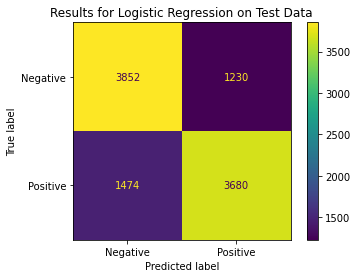

In [56]:
print_and_plot_results(y_test_cont, y_pred_logistic_final, "Logistic Regression", confusion_mat=True)

Classification Report for Voting Classifier: 
               precision    recall  f1-score   support

           0       0.72      0.76      0.74      5082
           1       0.75      0.71      0.73      5154

    accuracy                           0.73     10236
   macro avg       0.73      0.73      0.73     10236
weighted avg       0.73      0.73      0.73     10236



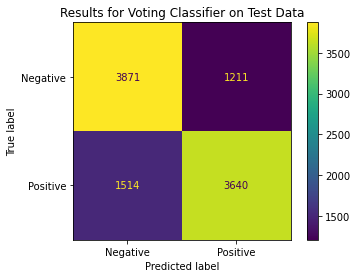

In [60]:
voting_classifier_predictions = voting_classifier.predict(X_test_cont)

print_and_plot_results(y_test_cont, voting_classifier_predictions, "Voting Classifier", confusion_mat=True)

From the results above, we can see that the simple (and fast) logistic regression model performed slightly better at accuracy compared to the VotingClassifier(). For the other metrics they perform the same. Because of this, and because it is also the most simple model, I choose to proceed with logistic regression. 

## 2.7 "Deploy" - spara modell
Börja med att plocka ut 100 slumpmässigt valda rader från ditt dataset. Exportera dessa 100 samples i
test_samples.csv. Därefter tar du den bästa modellen och träna på all data vi har förutom de 100
datapunkterna du plockade ut. Spara därefter modellen i en .pkl-fil med hjälp av joblib.dump(). För
modellen kan du behöva använda argumentet compress för att komprimera om filstorleken för stor.

In [57]:
X_train_deploy, X_test_deploy, y_train_deploy, _ = train_test_split(X_cont, y_cont, test_size=100, random_state=42)
X_train_deploy.shape, X_test_deploy.shape, y_train_deploy.shape

((68135, 12), (100, 12), (68135,))

In [58]:
X_test_deploy.to_csv("Data/test_samples.csv", index=False)

logistic_model_to_deploy = logistic_regression(X_train_deploy, y_train_deploy)

joblib.dump(logistic_model_to_deploy, "Model/cardio_predictor")

['Model/cardio_predictor']

### References
<a id="Mulder(2016)" href="#note1ref">1</sup></a>. Mulder, C.J., Wanten, G.J., Semrad, C.E., Jeppesen, P.B., Kruizenga, H.M., Wierdsma, N.J., ... van Bodegraven, A.A. (2016) Clinical nutrition in the hepatogastroenterology curriculum. *World Journal of Gastroenterology*, 22(5), 1729-1735. https://doi.org/10.3748/wjg.v22.i5.1729. 

<a id="Wynn(2007)" href="#note2ref">2</sup></a>. Wynn, J., King, T.M., Gambello, M.J., Waller, D.K., & Hecht, J.T. (2007). Mortality in achondroplasia study: a 42-year follow-up. *American Journal of Medical Genetics Part A*, 143A, 2502-2511. https://doi.org/10.1002/ajmg.a.31919

<a id="Park(2017)" href="#note3ref">3</sup></a>. Park, D., Lee, J. H., & Han, S. (2017). Underweight: another risk factor for cardiovascular disease?: A cross-sectional 2013 Behavioral Risk Factor Surveillance System (BRFSS) study of 491,773 individuals in the USA. *Medicine*, 96(48), e8769. https://doi.org/10.1097/MD.0000000000008769

<a id="Holland(2021)" href="#note4ref">4</sup></a>. Holland, K. (2021). Everything You Need to Know About High Blood Pressure (Hypertension). *Healthline*. Retrieved March 14, 2022, from https://www.healthline.com/health/high-blood-pressure-hypertension

<a id="MayoClinicStaff(2020)" href="#note5ref">5</sup></a>. Mayo Clinic Staff. (2020). Low blood pressure (hypotension). *Mayo Clinic*. Retrieved March 21, 2022, from https://www.mayoclinic.org/diseases-conditions/low-blood-pressure/symptoms-causes/syc-20355465

<a id="Gegenhuber(2003)" href="#note6ref">6</sup></a>. Gegenhuber, A., & Lenz, K., (2003). Behandlung des hypertensiven Notfalls [Hypertensive emergency and urgence]. *Herz*, 28(8), 717-724. https://doi.org/10.1007/s00059-003-2506-8. 